# Workflow of tracking LNO2

This notebook aims to show the steps to track lightning NO2 air parcels using lightning, wind, and TROPOMI NO2 observations.

Input:
- New L2 product generated by `s5p_main.py`: ../data/clean_lightning/S5P_PAL__L2__NO2____20190811T00*.nc
- Lightning NO2 production data generated by `s5p_lno2_pe_lifetime.py`: ../data/S5P_LNO2_production.nc

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import proplot as pplt
from glob import glob
from matplotlib.animation import FuncAnimation

pplt.rc.reso = 'med'

# Disable warnings
from warnings import filterwarnings
filterwarnings("ignore")

## Read S5P-LNO2 product

Data used in this notebook are produced by the [S5P-LNO2](https://github.com/zxdawn/S5P-LNO2) program.

In [2]:
filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190811T00*.nc')[0]

ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)
                # [['nitrogendioxide_tropospheric_column',
                  # 'nitrogendioxide_segmentation', 'lightning_mask']]

ds_lightning = xr.open_dataset(filename, group='Lightning')

## Overview of lightning and NO2

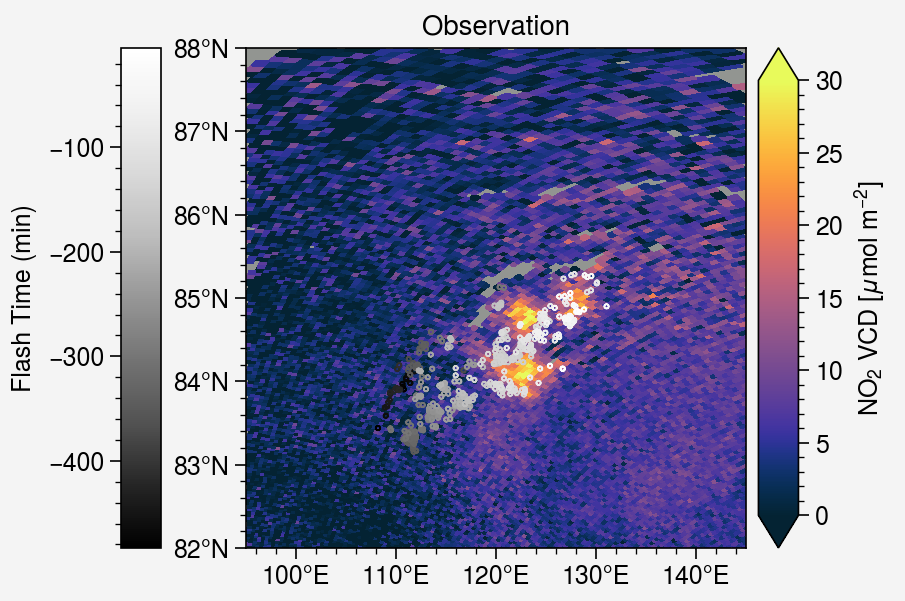

In [3]:
# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

def plot_obs(ds_tropomi, ds_lightning, ax, lon_min, lon_max, lat_min, lat_max, add_colorbar=False, title='Observation'):
    """Plot the observed lightning and NO2"""
    # plot NO2 background
    lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
    lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

    mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)

    no2 = ds_tropomi['nitrogendioxide_tropospheric_column']


    # plot NO2 VCD
    if add_colorbar == False:
        cbar_kwargs = None
    else:
        cbar_kwargs={'label': 'NO$_2$ VCD [$\mu$mol m$^{-2}$]'}
    (no2*1e6).where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude',
                                    cmap='Thermal', vmin=0, vmax=30, discrete=False,
                                    add_colorbar=add_colorbar,
                                    cbar_kwargs=cbar_kwargs,#, 'orientation': 'horizontal'},
                                    )

    # plot lightning
    s_obs = ax.scatter(ds_lightning['longitude'],
                       ds_lightning['latitude'],
                       marker="$\u25EF$", cmap='Greys_r',
                       c=ds_lightning['delta'], s=3)

    ax.colorbar(s_obs, loc='l', label='Flash Time (min)')
    ax.format(xlabel='', ylabel='', title=title)

fig, axs = pplt.subplots()

plot_obs(ds_tropomi, ds_lightning, axs, lon_min, lon_max, lat_min, lat_max, add_colorbar=True)

axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max), grid=False,
            xformatter='deglon', yformatter='deglat',
            #f'Lightning Tracer at {level.values} hPa',
            facecolor='gray')

# fig.savefig(f'../figures/wind_plevel/20190811_ground.png')

## Transport of lightning air parcel

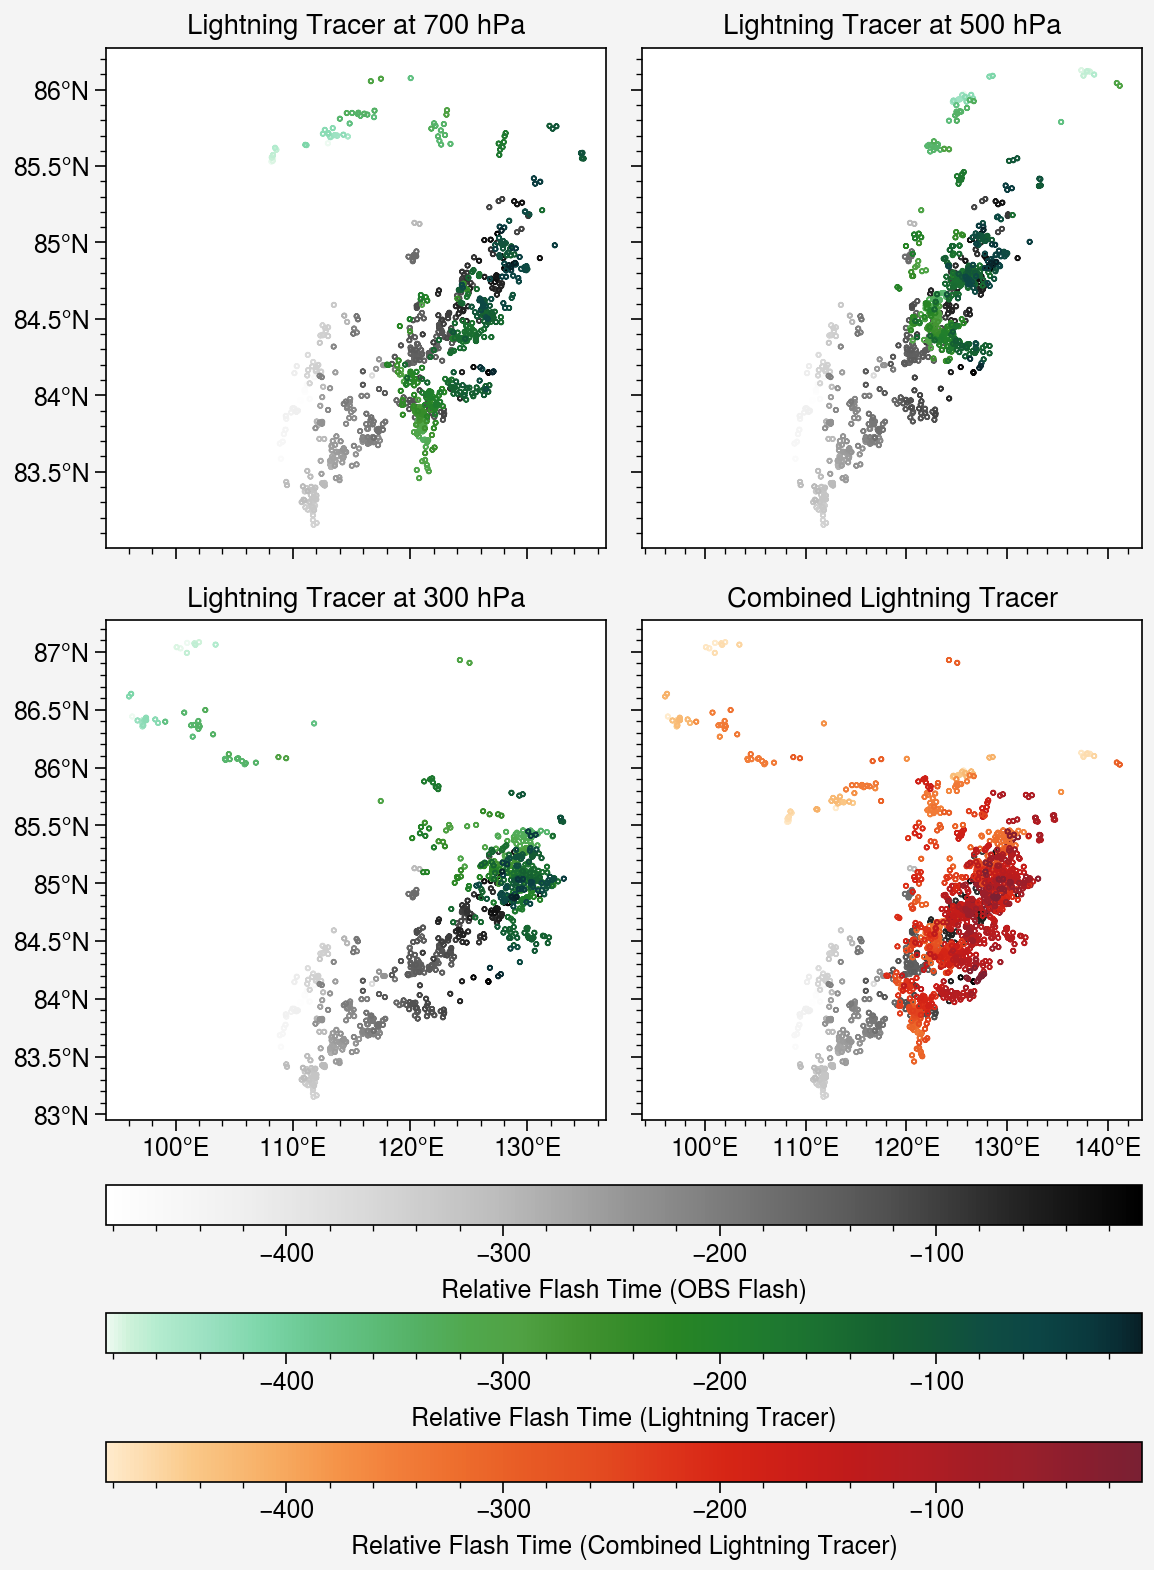

In [4]:
fig, axs = pplt.subplots(nrows=2, ncols=2, span=False, sharey=3, sharex=3)

s_obs = axs.scatter(ds_lightning['longitude'], ds_lightning['latitude'],
                marker="$\u25EF$", cmap='Greys',
                c=ds_lightning['delta'], s=3)

axs[0].scatter(ds_lightning['longitude_pred'].sel(level=700),
               ds_lightning['latitude_pred'].sel(level=700),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

axs[1].scatter(ds_lightning['longitude_pred'].sel(level=500),
               ds_lightning['latitude_pred'].sel(level=500),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

s_transport = axs[2].scatter(ds_lightning['longitude_pred'].sel(level=300),
               ds_lightning['latitude_pred'].sel(level=300),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

for level in ds_lightning.level:
    s_transport_comb = axs[3].scatter(ds_lightning['longitude_pred'].sel(level=level),
                ds_lightning['latitude_pred'].sel(level=level),
                marker="$\u25EF$", cmap='Reds2',
                c=ds_lightning['delta'], s=3)

fig.colorbar(s_obs[0], loc='b', label=f'Relative Flash Time (OBS Flash)')
fig.colorbar(s_transport, loc='b', label=f'Relative Flash Time (Lightning Tracer)')
fig.colorbar(s_transport_comb, loc='b', label=f'Relative Flash Time (Combined Lightning Tracer)')

axs.format(title=['Lightning Tracer at 700 hPa', 'Lightning Tracer at 500 hPa',
                  'Lightning Tracer at 300 hPa', 'Combined Lightning Tracer'],
           grid=False, xformatter='deglon', yformatter='deglat', xlabel='', ylabel='')

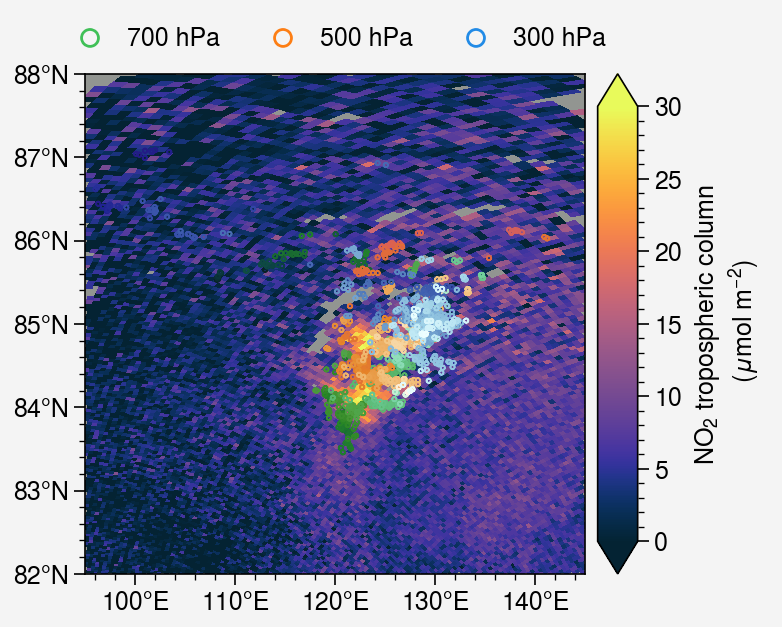

In [5]:
# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

def plot_tracer(ds_tropomi, ds_lightning, ax, lon_min, lon_max, lat_min, lat_max, add_colorbar=False):
    """Plot the lightning NO2 tracer at three pressure levels"""
    # plot NO2 background
    lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
    lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

    mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)

    no2 = ds_tropomi['nitrogendioxide_tropospheric_column']


    cmaps = ['Greens2_r', 'Oranges2_r', 'Blues2_r']

    # plot NO2 VCD
    if add_colorbar == False:
        cbar_kwargs = None
    else:
        cbar_kwargs={'label': 'NO$_2$ tropospheric column \n ($\mu$mol m$^{-2}$)'}
    (no2*1e6).where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude',
                                    cmap='Thermal', vmin=0, vmax=30, discrete=False,
                                    add_colorbar=add_colorbar, rasterized=True,
                                    cbar_kwargs=cbar_kwargs,#, 'orientation': 'horizontal'},
                                    )

    for index,level in enumerate(ds_lightning.level):
        # plot lightning
        s_pred = ax.scatter(ds_lightning['longitude_pred'].sel(level=level),
                            ds_lightning['latitude_pred'].sel(level=level),
                            marker="$\u25EF$", cmap=cmaps[index],
                            c=ds_lightning['delta'], s=3,
                            label=str(level.values)+' hPa')
    
    leg = ax.legend(loc='t', frame=False, markerscale=4)
    leg.legendHandles[0].set_color('green6')
    leg.legendHandles[1].set_color('orange6')
    leg.legendHandles[2].set_color('blue6')

    ax.format(xlabel='', ylabel='', title='')#title='Lightning tracer',)

fig, axs = pplt.subplots()

plot_tracer(ds_tropomi, ds_lightning, axs, lon_min, lon_max, lat_min, lat_max, add_colorbar=True)

axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max), grid=False,
            xformatter='deglon', yformatter='deglat',
            facecolor='gray')

### Animation

In [6]:
# fig, ax = pplt.subplots()

# # set plot region
# lon_min = 95; lon_max = 145
# lat_min = 82; lat_max = 88

# # plot NO2 background
# lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
# lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

# mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
# no2 = ds_tropomi['nitrogendioxide_tropospheric_column']
# no2.where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude',
#                                 cmap='Thermal', vmin=0, vmax=4e-5, discrete=False,
#                                 cbar_kwargs={'label': '[mol m$^{-2}$]'},
#                                 alpha=0.8)


# # plot OBS lightning
# s_obs = ax.scatter(ds_lightning['longitude'], ds_lightning['latitude'],
#            marker="$\u25EF$", cmap='Greys_r',
#            c=ds_lightning['delta'], s=3)

# def animate(level):
#     ax.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max), grid=False,
#           xformatter='deglon', yformatter='deglat', xlabel='', ylabel='')

#     animate.scatter.remove()
#     animate.scatter = ax.scatter(ds_lightning['longitude_pred'].sel(level=level),
#                 ds_lightning['latitude_pred'].sel(level=level),
#                 marker="$\u25EF$", cmap='Greens2_r',
#                 c=ds_lightning['delta'], s=3)

#     ax.set_title(f'Lightning Tracer at {level} hPa')

# animate.scatter = ax.scatter([], [])

# anim = FuncAnimation(fig, animate, interval=1000, frames=ds_lightning.level.values, repeat=True)
# anim.save('lightning_tracer_transport.gif', dpi=600)
# fig.clf()

In [7]:
# from IPython.display import HTML
# HTML('<img src="lightning_tracer_transport.gif">')

## Mask NO2

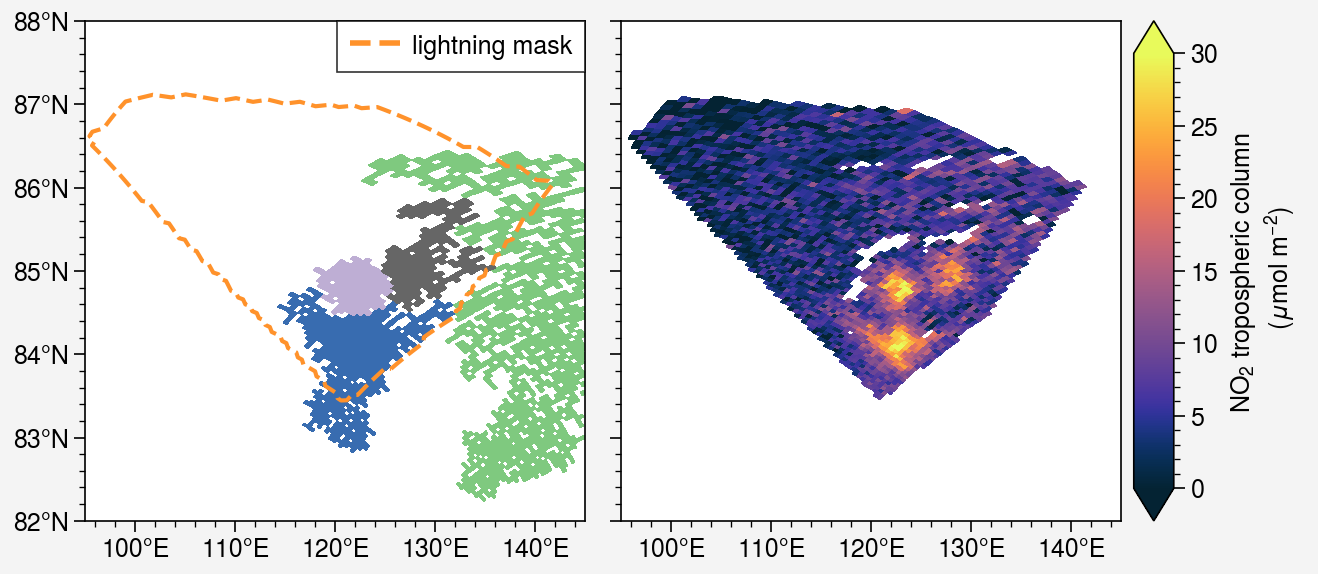

In [8]:
# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88


def plot_mask(ds_tropomi, axs, lon_min, lon_max, lat_min, lat_max):
    """Plot the mask of lightning NO2"""
    lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
    lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

    mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)

    segmentation = ds_tropomi['nitrogendioxide_segmentation'].where(mask, drop=True)
    segmentation.where(segmentation>0).plot(x='longitude', y='latitude', ax=axs[0], cmap='Accent', add_colorbar=False, rasterized=True)

    # ds_tropomi['lightning_mask'].where(mask, drop=True).plot(ax=axs[2], x='longitude', y='latitude', add_colorbar=False)
    axs[0].contour(ds_tropomi['lightning_mask'].longitude, ds_tropomi['lightning_mask'].latitude,
                ds_tropomi['lightning_mask'], levels=[1], colors=['orange5'], ls='--')
    l = plt.Line2D((0, 1), (0, 0), color='orange5', linestyle='--', linewidth=2)
    axs[0].legend([l], ['lightning mask'])

    axs[0].format(xlabel='', ylabel='', title='')#'NO$_2$ segmentation \n overlayed with lightning mask')

    no2 = ds_tropomi['nitrogendioxide_tropospheric_column']
    # scd_trop = ds_tropomi['nitrogendioxide_slant_column_density'] - ds_tropomi['nitrogendioxide_stratospheric_column'] * ds_tropomi['air_mass_factor_stratosphere']
    (no2*1e6).where(ds_tropomi['lightning_mask']>0).plot(ax=axs[1], x='longitude', y='latitude',
                                                cmap='Thermal', vmin=0, vmax=30, discrete=False, rasterized=True,
                                                cbar_kwargs={'label': 'NO$_2$ tropospheric column \n ($\mu$mol m$^{-2}$)'})
    axs[1].format(xlabel='', ylabel='', title='')#'Masked NO$_2$')


fig, axs = pplt.subplots(ncols=2)

plot_mask(ds_tropomi, axs, lon_min, lon_max, lat_min, lat_max)

axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglon', yformatter='deglat',
           grid=False)

In [9]:
ds_t0 = xr.open_dataset('../data/S5P_LNO2_production.nc', group='/Case11/Swath09456/S5P').isel(time=0)
ds_t1 = xr.open_dataset('../data/S5P_LNO2_production.nc', group='/Case11/Swath09457/S5P').isel(time=0)
ds_t2 = xr.open_dataset('../data/S5P_LNO2_production.nc', group='/Case11/Swath09458/S5P').isel(time=0)
ds_t3 = xr.open_dataset('../data/S5P_LNO2_production.nc', group='/Case11/Swath09459/S5P').isel(time=0)

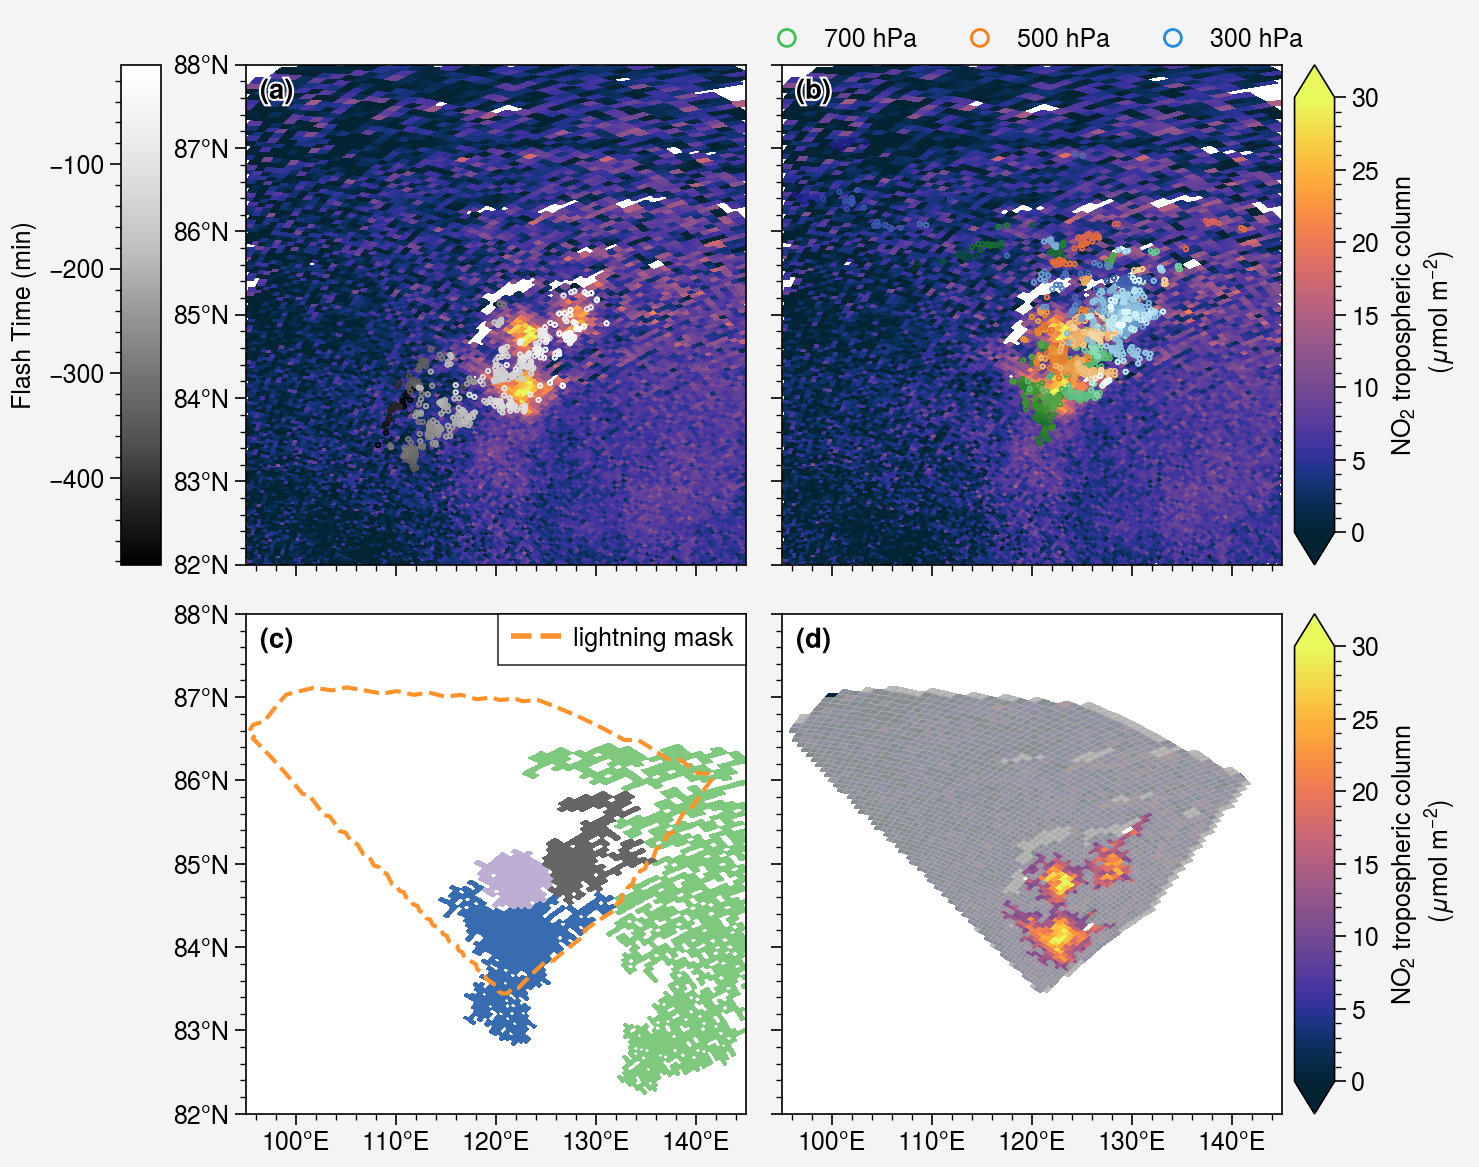

In [10]:
# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

fig, axs = pplt.subplots(nrows=2, ncols=2, span=False, sharey=3, sharex=3)

# plot steps
plot_obs(ds_tropomi, ds_lightning, axs[0], lon_min, lon_max, lat_min, lat_max, title='')
plot_tracer(ds_tropomi, ds_lightning, axs[1], lon_min, lon_max, lat_min, lat_max, add_colorbar=True)
plot_mask(ds_tropomi, axs[2:4], lon_min, lon_max, lat_min, lat_max)

ds_t2['lno2_mask'].where((ds_t2['lno2_mask']==0)&(ds_t2['lightning_mask']>0)).plot(ax=axs[3], x='longitude', y='latitude', cmap='Greys', add_colorbar=False, alpha=0.8, rasterized=True)
axs[3].format(title='')

axs.format(xlabel='', ylabel='', xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglon', yformatter='deglat',
           grid=False, abcloc='ul', abc='(a)')


fig.savefig('../figures/workflow.pdf')

Overview of the process for selecting lightning NO2 pixels from TROPOMI orbit 09458 on August 1, 2019.

The TROPOMI-detected NO2 tropospheric columns overlaid with (a) observed lightning strokes and (b) transported air parcels of lightning NO2 at three pressure levels (300 hPa [blue], 500 hPa [orange], and 700 hPa [green]).

(c) Parcels are combined into one lightning mask (orange circle), which is overlapped with the high NO2 selections (filled pixels). The different pixel colors represent different NO2 selections based on multiple NO2 thresholds.

(d) The final selection (bright pixels) of NO2 tropospheric columns affected by lightning NO2 (bright pixels) within the mask.

## SCD v.s. VCD

## Example of consecutive orbits

In [11]:
ds_lifetime_t1 = xr.open_dataset('../data/S5P_LNO2_lifetime.nc', group='/Case2/Swath19394/S5P').isel(time=0)
ds_lifetime_t2 = xr.open_dataset('../data/S5P_LNO2_lifetime.nc', group='/Case2/Swath19395/S5P').isel(time=0)

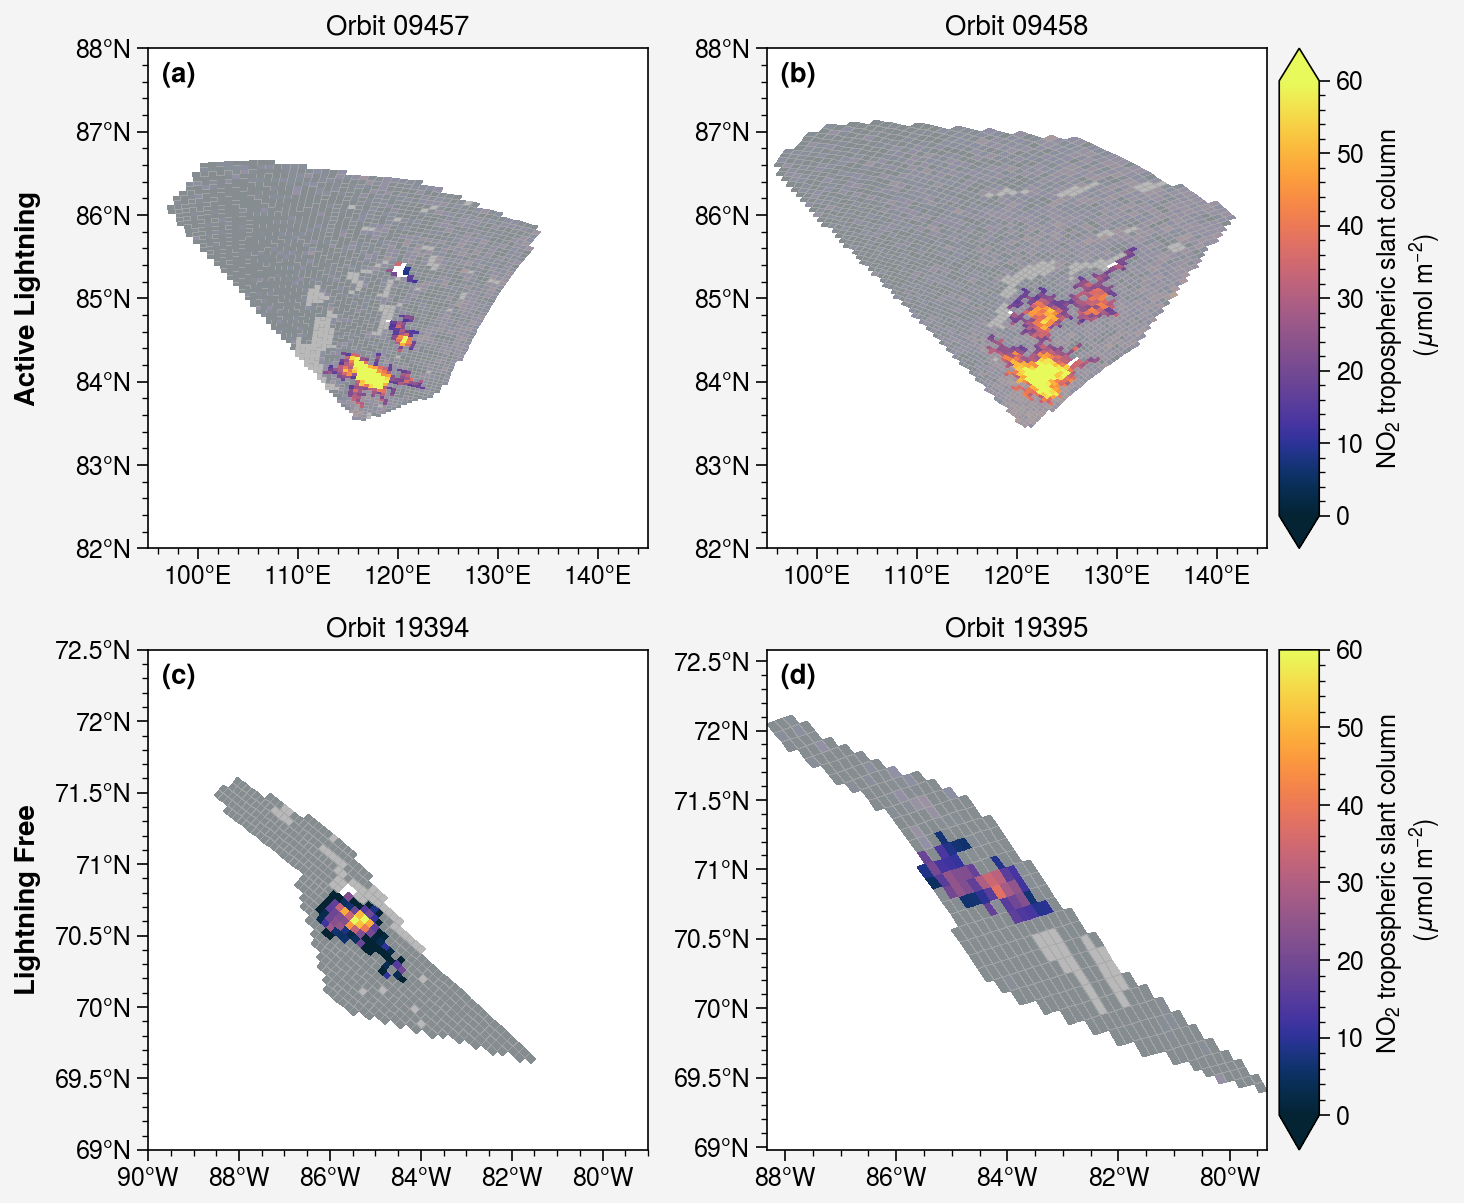

In [12]:
fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

############### subplot 1 ###############
(ds_t1['scdTrop']*1e6).where(ds_t1['lightning_mask']>0).plot(ax=axs[0], x='longitude', y='latitude',
                                            cmap='Thermal', vmin=0, vmax=60, discrete=False,
                                            add_colorbar=False, rasterized=True
                                            )

ds_t1['lno2_mask'].where((ds_t1['lno2_mask']==0)&(ds_t1['lightning_mask']>0)).plot(ax=axs[0], x='longitude', y='latitude', cmap='Greys', add_colorbar=False, alpha=0.8, rasterized=True)

############### subplot 2 ###############
(ds_t2['scdTrop']*1e6).where(ds_t2['lightning_mask']>0).plot(ax=axs[1], x='longitude', y='latitude',
                                            cmap='Thermal', vmin=0, vmax=60, discrete=False, rasterized=True,
                                            cbar_kwargs={'label': 'NO$_2$ tropospheric slant column \n ($\mu$mol m$^{-2}$)'})

ds_t2['lno2_mask'].where((ds_t2['lno2_mask']==0)&(ds_t2['lightning_mask']>0)).plot(ax=axs[1], x='longitude', y='latitude', cmap='Greys', add_colorbar=False, alpha=0.8, rasterized=True)



############### subplot 3 ###############
(ds_lifetime_t1['scdTrop']*1e6).where(ds_lifetime_t1['lightning_mask']>0).plot(ax=axs[2], x='longitude', y='latitude',
                                            cmap='Thermal', vmin=0, vmax=60, discrete=False,
                                            add_colorbar=False, rasterized=True,
                                            )

ds_lifetime_t1['lno2_mask'].where((ds_lifetime_t1['lno2_mask']==0)&(ds_lifetime_t1['lightning_mask']>0)).plot(ax=axs[2], x='longitude', y='latitude', cmap='Greys', add_colorbar=False, alpha=0.8, rasterized=True)


############### subplot 4 ###############
(ds_lifetime_t2['scdTrop']*1e6).where(ds_lifetime_t2['lightning_mask']>0).plot(ax=axs[3], x='longitude', y='latitude',
                                            cmap='Thermal', vmin=0, vmax=60, discrete=False, rasterized=True,
                                            cbar_kwargs={'label': 'NO$_2$ tropospheric slant column \n ($\mu$mol m$^{-2}$)'})

ds_lifetime_t2['lno2_mask'].where((ds_lifetime_t2['lno2_mask']==0)&(ds_lifetime_t2['lightning_mask']>0)).plot(ax=axs[3], x='longitude', y='latitude', cmap='Greys', add_colorbar=False, alpha=0.8, rasterized=True)


title=['Orbit '+ds_t1.attrs['s5p_filename'].split('_')[-4], 'Orbit '+ds_t2.attrs['s5p_filename'].split('_')[-4],
       'Orbit '+ds_lifetime_t1.attrs['s5p_filename'].split('_')[-4], 'Orbit '+ds_lifetime_t2.attrs['s5p_filename'].split('_')[-4],]

axs[:2].format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max))
axs[2].format(xlim=(-90, -79), ylim=(69, 72.5))

axs.format(xlabel='', ylabel='',
           leftlabels=['Active Lightning', 'Lightning Free'],
           xformatter='deglon', yformatter='deglat',
           grid=False, abcloc='ul', abc='(a)',
           title=title
           )

fig.savefig('../figures/consecutive_orbits.pdf')